In [18]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from random import random
import idx2numpy
import pickle 

In [2]:
trainInputFile = 'train-images-idx3-ubyte'
trainLabelFile = 'train-labels-idx1-ubyte'
testInputFile = 't10k-images-idx3-ubyte'
testLabelFile = 't10k-labels-idx1-ubyte'

trainX = idx2numpy.convert_from_file(trainInputFile)
trainY = idx2numpy.convert_from_file(trainLabelFile)
testX = idx2numpy.convert_from_file(testInputFile)
testY = idx2numpy.convert_from_file(testLabelFile)

In [3]:
print("length of the training data is : {}" .format(len(trainX)))
print("length of the training data is : {}" .format(len(trainY)))
print("length of the test data is : {}" .format(len(testX)))
print("length of the test data is : {}" .format(len(testY)))

length of the training data is : 60000
length of the training data is : 60000
length of the test data is : 10000
length of the test data is : 10000


In [4]:
print("the structure train inputs in is : {}" .format(type(trainX)))
print("the structure rain labels in is : {}" .format(type(trainY)))
print("the structure test inputs in is : {}" .format(type(testX)))
print("the structure test labels in is : {}" .format(type(testY)))

the structure train inputs in is : <class 'numpy.ndarray'>
the structure rain labels in is : <class 'numpy.ndarray'>
the structure test inputs in is : <class 'numpy.ndarray'>
the structure test labels in is : <class 'numpy.ndarray'>


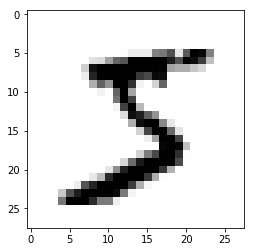

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

In [66]:
plt.imshow(trainX[0], cmap = plt.cm.binary)
plt.show()

print(trainX[0])

In [6]:
# normalize the arrays
newMin, newMax, oldMin, oldMax = (0 , 1 , trainX.min() , trainX.max())

# https://en.wikipedia.org/wiki/Normalization_(image_processing)
trainX = (trainX - oldMin) * ((newMax - newMin) / (oldMax - oldMin)) + newMin

newMin, newMax, oldMin, oldMax = (0 , 1 , testX.min() , testX.max())

testX = (testX - oldMin) * ((newMax - newMin) / (oldMax - oldMin)) + newMin

In [7]:
class MLP(object):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        
        self.layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]
        
        self.activations = []
        self.weights = []
        self.biases = []
        self.d_weights = []
        self.d_biases = []
        
        # initialize random weights
        # create derivatives for weights
        # initialize random biases
        # create derivatives for biases
        
        for i in range(len(self.layers) - 1):
            weights = 0.01 * np.random.rand(self.layers[i], self.layers[i + 1])
            self.weights.append(weights)
            
            self.d_weights.append(np.zeros((self.layers[i] , self.layers[i + 1])))
            
            biases = 0.01 * np.random.rand(self.layers[i + 1])
            self.biases.append(biases)
            
            self.d_biases.append(np.zeros(self.layers[i + 1]))            
            
        
        # create activations per layer
        for i in range(len(self.layers)):
            activation = np.zeros(self.layers[i])
            self.activations.append(activation)
            
        
    def forward(self, inputs):
        self.activations[0] = inputs
        activations = inputs

        for i, weights in enumerate(self.weights):
            z = np.dot(activations, weights) + self.biases[i]

            if i != len(self.weights) - 1:                
                activations = self.relu(z)
            else:
                activations = self.softmax(z)

            self.activations[i + 1] = activations

        return activations # output
        
        
    def train(self, inputs, labels, learningRate, epochs):
        for i in range(epochs):
            sumError = 0
            for j,data in enumerate(inputs):
                label = labels[j]

                target = np.zeros(self.num_outputs)
                target[label] = 1

                # flatten img to 1d array
                data = data.flatten() 
                output = self.forward(data)
                d_error = output - target
                    
                self.backpropagate(d_error)          

                self.gradient_descent(learningRate)

                sumError += self.categorical_cross_entropy_loss(target, output)

            print("Error: {} at epoch {}".format(sumError / len(inputs), i+1))
        
    def backpropagate(self, d_error):
        # dC / dZ = output(k) - target(k)  categorical cross entropy loss
        # dC/dW(l) = dC/dA * dA/dZ * dZ/dW(l-1)
        # dC/db(l) = dC/dA * dA/dZ * 1
        # dC/dW(l-1) = dC/dA * dA/dZ * dZ(l)/dA(l-1) * dA(l-1)/dZ(l-1) * dZ(l-1)/dW(l-1)
        for i in reversed(range(len(self.d_weights))):

            activations = self.activations[i + 1]
            
            if i == len(self.d_weights) - 1:
                commonDerivative = d_error
            else:
                commonDerivative = d_error * self.d_relu(activations)

            re_commonDerivative = commonDerivative.reshape(commonDerivative.shape[0], -1).T # 2d, 1 row

            # get activations for current layer
            current_activations = self.activations[i]
            # reshape activations as to have them as a 2d column matrix
            current_activations = current_activations.reshape(current_activations.shape[0],-1) #2d, 1 col

            self.d_weights[i] = np.dot(current_activations, re_commonDerivative)
            self.d_biases[i] = commonDerivative

            # backpropogate the error - the common part          
            d_error = np.dot(commonDerivative, self.weights[i].T)

    def gradient_descent(self, learningRate):
        for i in range(len(self.d_weights)):
            d_weights = self.d_weights[i]
            self.weights[i] = self.weights[i] - d_weights * learningRate

            d_biases = self.d_biases[i]
            self.biases[i] = self.biases[i] - d_biases * learningRate

    def relu(self, x):
        return x * (x > 0)

    def d_relu(self, x):
        return 1 * (x > 0)

    def softmax(self, x):
        values = np.exp(x - np.amax(x))
        values = values / np.sum(values)
        values_clipped = np.clip(values, 1e-7, 1 - 1e-7)
        return values_clipped

    def categorical_cross_entropy_loss(self, targets, outputs):
        return -np.sum(targets * np.log(outputs))


In [8]:
# create a Multilayer Perceptron with one hidden layer
mlp = MLP(784, [128,128,64], 10)

# train network
mlp.train(trainX, trainY, 0.01, 10)

Error: 1.0671453769464563 at epoch 1
Error: 0.20105802637528225 at epoch 2
Error: 0.12289884799910088 at epoch 3
Error: 0.0928216050233742 at epoch 4
Error: 0.07433306912124328 at epoch 5
Error: 0.06203951415262141 at epoch 6
Error: 0.05190247262233346 at epoch 7
Error: 0.045943723425489164 at epoch 8
Error: 0.04304998493053449 at epoch 9
Error: 0.038324967600418744 at epoch 10


In [9]:
correct = 0
class_names = [str(i) for i in range(10)]
conf_matrix = np.zeros((len(class_names), len(class_names)))
for i, (data,label) in enumerate(zip(testX,testY)):
    predict = np.argmax(mlp.forward(data.flatten()))
    if label == predict:
        correct += 1
        
    conf_matrix[label][predict] += 1

accuracy = (correct / len(testY)) * 100
print("accuracy is : {}%" .format(accuracy))

accuracy is : 96.94%


In [10]:
# from scikitlearn 0.18 - old version
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

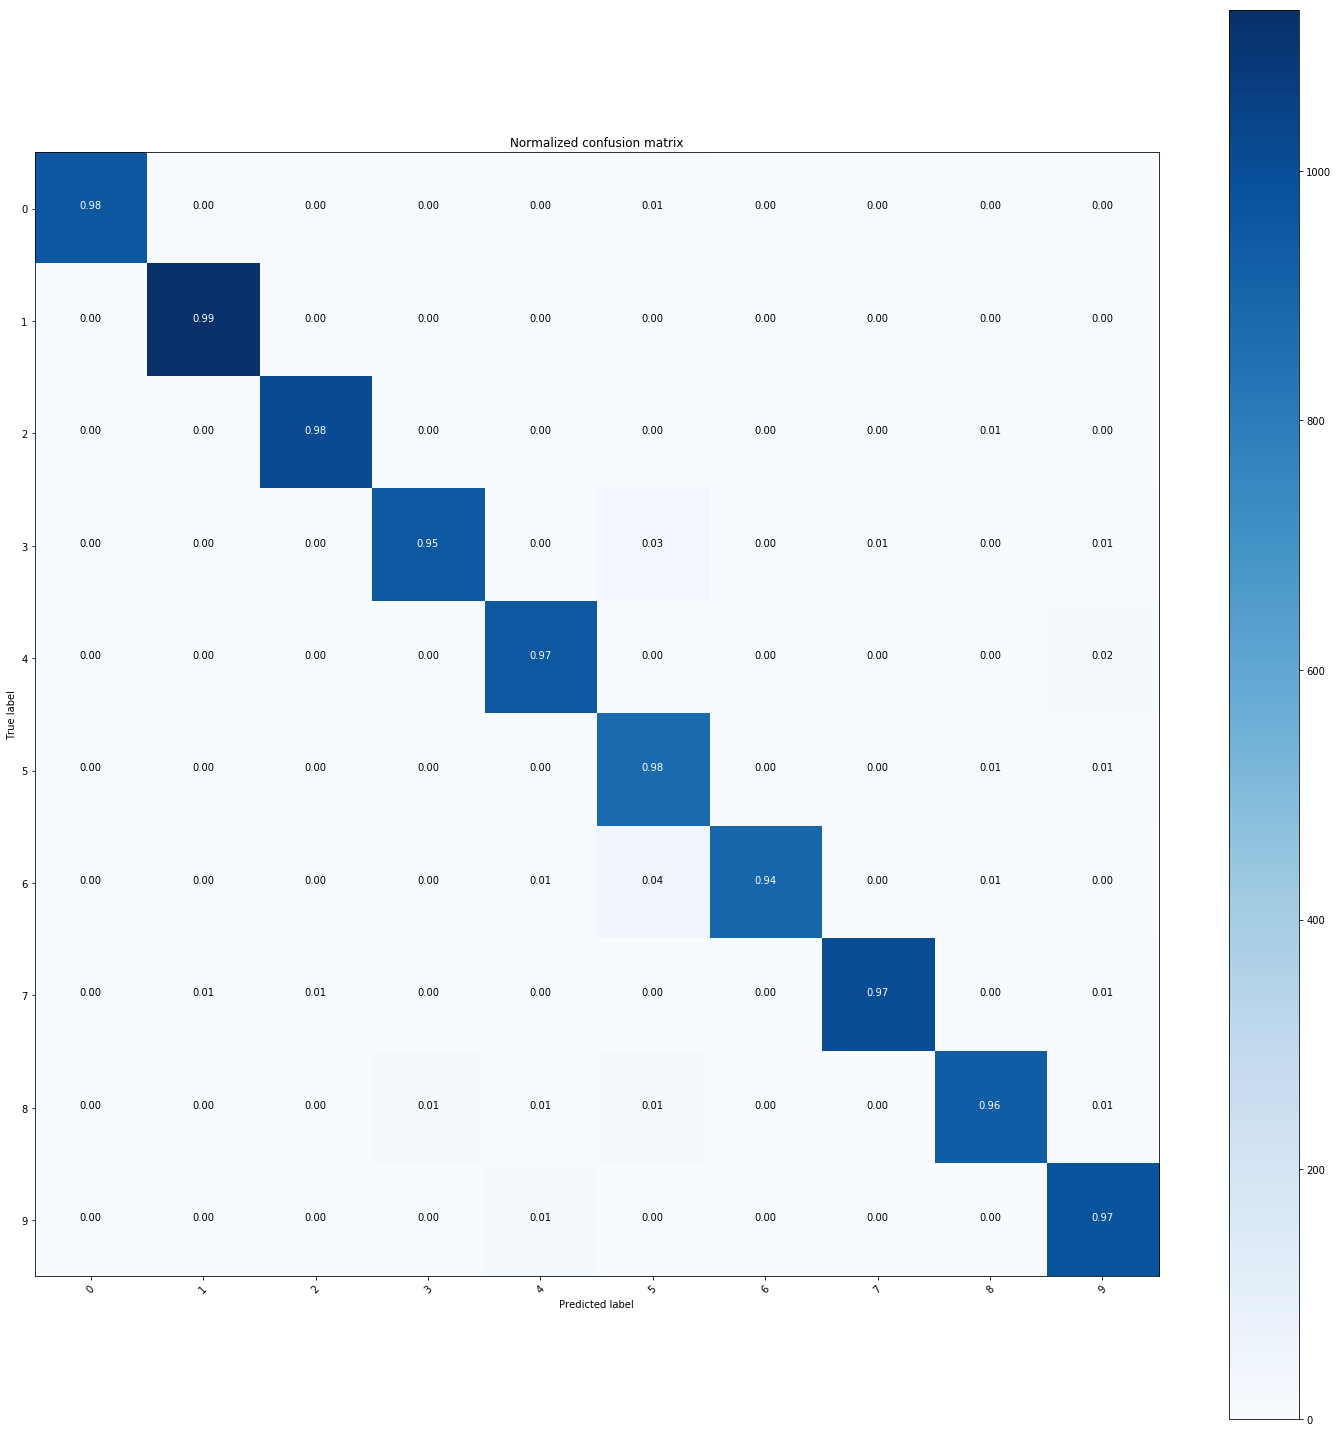

In [11]:
plt.figure()
plt.figure(figsize=(20,20))

plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
pickle_out = open("weights.pickle", "wb")
pickle.dump(mlp.weights, pickle_out)
pickle_out.close()

pickle_out = open("biases.pickle", "wb")
pickle.dump(mlp.biases, pickle_out)
pickle_out.close()

file = open("layers.txt", "w")

line = str(mlp.num_inputs) + " "
for i in range(len(mlp.num_hidden)):
        line += str(mlp.num_hidden[i]) + " "
line += str(mlp.num_outputs)        
file.write(line)
file.close()

In [57]:
# these files can be extracted like this.
'''
pickle_in = open("weights.pickle", "rb")
weights = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("biases.pickle", "rb")
biases = pickle.load(pickle_in)
pickle_in.close()

file = open("layers.txt", "r")
line = file.read().strip().split(" ")
file.close()

num_inputs = int(line[0])
num_outputs = int(line[len(line) - 1])

line.pop(0)
line.pop(len(line) - 1)

num_hidden = [int(num) for num in line]
'''

